# Data from Angeles Point (Station 46267) and Neah Bay (Station 46087)

This code:
*   Loads data from Angeles Point and Neah Bay
*   Creates plots and runs linear regressionsfor ~8 months of overlapping Angeles
*   Calculates wavelength for Angeles Point

WVHT = significant wave height (m)

DPD = dominant wave period (sec)

MWD = direction that waves are coming from (degrees)

In [1]:
# Import NumPy, xarray, Matplotlib (and related imports)
import os
import glob    
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil import parser as date_parser
import seaborn as sns
from scipy import stats 
import scipy.stats as linregress
import statsmodels.api as sm
import math

# Give Colab access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
neah_bay = '/content/drive/MyDrive/Elwha project/Station 46087 - Neah Bay (April-November 2020).txt'
angeles_point = '/content/drive/MyDrive/Elwha project/Station 46267 - Angeles Point, WA (April-November 2020).txt'

def clean_line(line):
  line_list = line.split(' ')
  line_list[-1] = line_list[-1].replace("\n", "")
  line_list = [i for i in line_list if i]
  return line_list                 # remove the spaces

def get_header(path):
  with open(path, 'r') as fp:
    h_full = []
    h1 = clean_line(fp.readline())
    h2 = clean_line(fp.readline())
    for e1, e2 in zip(h1, h2):
      h_full.append(f'{e1} {e2}')   # combine two header lines into 1 line
    return h_full

def load_dataframe(path, header):
  with open(path, 'r') as fp:
    fp.readline()
    fp.readline()
    data = []
    for i, line in enumerate(fp):
      line_list = clean_line(line)
      data.append(line_list)
  return pd.DataFrame(data, columns=header)

# Turn 99.0 and 999.0 into NaN
def format_dataframe(df):
  df = df.rename(columns={'#YY #yr': 'Year', 'MM mo': 'Month', 'DD dy': 'Day', 'hh hr': 'Hour', 'mm mn': 'Minute'})
  df.loc[:, ['Year', 'Month', 'Day', 'Hour', 'Minute']] = df.loc[:, ['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(int)
  df = df.astype({'WDIR degT': int, 'WSPD m/s': float, 'GST m/s': float, 'WVHT m': float, 'DPD sec': float, 'APD sec': float, 'MWD degT': int, 'PRES hPa': float, 'ATMP degC': float, 'WTMP degC': float, 'DEWP degC': float, 'VIS mi':float, 'TIDE ft': float})
  df = df.replace(to_replace={99: np.NaN, 999: np.NaN})
  return df

def get_date(year, month, day, hour, min):
  return f"{year}-{month}-{day} {hour}:{min}"
  

In [3]:
# Neah Bay DataFrame
neah_df = load_dataframe(neah_bay, get_header(neah_bay))
neah_df = format_dataframe(neah_df)

# Change the minute column to have "20" --> "30" and "50" --> "00"
def neah_minute_change(Minute):
  if Minute == 20:
    return 30
  elif Minute == 50:
    return 0
  else:
    return Minute

# For every 0 minute, increase the hour by 1
def neah_hour_change(row):
  if row.Minute == 0:
    return row.Hour + 1
  else:
    return row.Hour

# For every 24 hour, decrease the hour to 0
def neah_24hour_change(row24):
  if row24.Hour == 24:
    return row24.Hour - 24
  else:
    return row24.Hour

# For every 0 day and 0 minute, increase the day by 1. The last date of the month was manually changed to 00 so the code increases the month by 1
def neah_day_change(day):
  if day.Hour == 0 and day.Minute == 0:
    return day.Day + 1 
  else:
    return day.Day

# Apply Neah Minute, Hour, Day changes
neah_df['Minute'] = neah_df['Minute'].apply(neah_minute_change)
neah_df['Hour'] = neah_df.apply(lambda row: neah_hour_change(row), axis=1)
neah_df['Hour'] = neah_df.apply(lambda row24: neah_24hour_change(row24), axis=1)
neah_df['Hour'] = neah_df['Hour'].astype(int)
neah_df['Day'] = neah_df.apply(lambda day: neah_day_change(day), axis=1)
neah_df['Day'] = neah_df['Day'].astype(int)

# Combine year, month, etc, into date column. Change date column from object/string into datetime
neah_df['Date'] = neah_df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = neah_df.pop('Date')
neah_df.insert(0, "Date", date_col)
neah_df.loc[:,'Date'] = pd.to_datetime(neah_df['Date'], format='%Y-%m-%d %H:%M')

# Fill missing rows with NaNs. Frequency is '30T' which is every 30 minutes.
neah_df.index = neah_df['Date']
neah_df.drop(columns=['Date','Year','Month','Day','Hour','Minute'], inplace = True)
neah_missing_dates = pd.Series(index=pd.date_range(neah_df.index.min(), neah_df.index.max(), freq='30T')\
              .difference(neah_df.index))
neah_df = pd.concat([neah_df, neah_missing_dates]).sort_index()
neah_df.index = pd.to_datetime(neah_df.index)
neah_df.to_csv('neah df overlap year only.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [4]:
# Angeles Point DataFrame
remove_columns = ['Depth m', 'PRES hPa', 'WSPD m/s', 'WDIR degT', 'ATMP degC'] # Remove blank columns
angeles_header = get_header(angeles_point)
for el in remove_columns:
  angeles_header.remove(el)

angeles_df = load_dataframe(angeles_point, angeles_header)
angeles_df = angeles_df.rename(columns={'#YY #yr': 'Year', 'MM mo': 'Month', 'DD dy': 'Day', 'hh hr': 'Hour', 'mm mn': 'Minute'})
angeles_df.loc[:, ['Year', 'Month', 'Day', 'Hour', 'Minute']] = angeles_df.loc[:, ['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(int)
angeles_df = angeles_df.astype({'WVHT m': float, 'DPD sec': float, 'APD sec': float, 'MWD deg': float, 'WTMP degC': float, 'Cspd m/s': float, 'Cdir deg': float})
angeles_df['WVHT m'].where(angeles_df['WVHT m'] <= 3, np.NaN, inplace=True) # Replace waveheigh values above 3 with NaN

# Combine year month, etc into date col. Change date column from object/string into datetime
angeles_df['Date'] = angeles_df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = angeles_df.pop('Date')
angeles_df.insert(0, "Date", date_col)
angeles_df.loc[:,'Date'] = pd.to_datetime(angeles_df['Date'], format='%Y-%m-%d %H:%M')

# Fill missing rows with NaNs. Frequency is '30T' which is every 30 minutes.
angeles_df.index = angeles_df['Date']
angeles_df.drop(columns=['Date','Year','Month','Day','Hour','Minute'], inplace = True)
angeles_missing_dates = pd.Series(index=pd.date_range(angeles_df.index.min(), angeles_df.index.max(), freq='30T')\
              .difference(angeles_df.index))
angeles_df = pd.concat([angeles_df, angeles_missing_dates]).sort_index()
angeles_df.index = pd.to_datetime(angeles_df.index)
angeles_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,0,APD sec,Cdir deg,Cspd m/s,DPD sec,MWD deg,P f,WTMP degC,WVHT m
2020-04-01 16:00:00,NaN,6.89,261.0,0.12,10.00,299.0,1,7.1,0.46
2020-04-01 16:30:00,NaN,5.56,297.0,0.11,9.52,301.0,1,6.8,0.53
2020-04-01 17:00:00,NaN,3.81,289.0,0.15,10.53,298.0,1,7.1,0.63
2020-04-01 17:30:00,NaN,3.26,239.0,0.27,10.00,299.0,1,7.6,0.62
2020-04-01 18:00:00,NaN,3.45,247.0,0.41,10.53,304.0,1,7.8,0.63
...,...,...,...,...,...,...,...,...,...
2020-11-23 12:30:00,NaN,9.77,100.0,0.18,12.50,302.0,1,9.0,0.88
2020-11-23 13:00:00,NaN,9.25,104.0,0.28,12.50,295.0,1,8.7,0.96
2020-11-23 13:30:00,NaN,9.12,237.0,0.28,13.33,300.0,1,9.2,1.02
2020-11-23 14:00:00,NaN,8.52,241.0,0.22,12.50,300.0,1,9.2,1.02


In [5]:
# Percent of Angeles Point wave direction values that are less than 200°
mwd_below_twohundred = angeles_df['MWD deg'][angeles_df['MWD deg'] < 200].count()
total_mwd = angeles_df['MWD deg'].count()
print(mwd_below_twohundred, 'values less than 200°')
print(total_mwd, 'total wave direction values')
percent_below_twohund = (mwd_below_twohundred / total_mwd)*100
print(percent_below_twohund, '% of wave direction values are less than 200°')

327 values less than 200°
11241 total wave direction values
2.9089938617560716 % of wave direction values are less than 200°


In [6]:
# Percent of Neah Bay wave direction values between x and x degrees
total_mwd = neah_df['MWD degT'].count()
print(total_mwd, 'total wave direction values')
mwd = neah_df['MWD degT'][neah_df['MWD degT'].between(236,326)]
mwd_count = mwd.count()
print(mwd_count)

percent_mwd = (mwd_count / total_mwd)*100
print(percent_mwd, '%')

11096 total wave direction values
10210
92.01514059120403 %


In [7]:
# Select Neah Bay wave direction values between... and create new dataframe.
one_neah_df = neah_df[neah_df['MWD degT'].between(246, 260)]
two_neah_df = neah_df[neah_df['MWD degT'].between(260,274)]
three_neah_df = neah_df[neah_df['MWD degT'].between(274,288)]
four_neah_df = neah_df[neah_df['MWD degT'].between(288,302)]

# Select same rows for Angeles Point wave direction as selected previously for Neah Bay, and create new dataframe.
one_angeles_df = angeles_df.loc[one_neah_df.index]
two_angeles_df = angeles_df.loc[two_neah_df.index]
three_angeles_df = angeles_df.loc[three_neah_df.index]
four_angeles_df = angeles_df.loc[four_neah_df.index]

one_wvht_df = pd.concat([one_angeles_df['WVHT m'],one_neah_df['WVHT m']], axis=1)
two_wvht_df = pd.concat([two_angeles_df['WVHT m'],two_neah_df['WVHT m']], axis=1)
three_wvht_df = pd.concat([three_angeles_df['WVHT m'],three_neah_df['WVHT m']], axis=1)
four_wvht_df = pd.concat([four_angeles_df['WVHT m'],four_neah_df['WVHT m']], axis=1)

one_wvht_df.columns.values[0]='Angeles Point WVHT m'
one_wvht_df.columns.values[1]='Neah Bay WVHT m'
two_wvht_df.columns.values[0]='Angeles Point WVHT m'
two_wvht_df.columns.values[1]='Neah Bay WVHT m'
three_wvht_df.columns.values[0]='Angeles Point WVHT m'
three_wvht_df.columns.values[1]='Neah Bay WVHT m'
four_wvht_df.columns.values[0]='Angeles Point WVHT m'
four_wvht_df.columns.values[1]='Neah Bay WVHT m'

r squared: 0.2496691464440639 0.22479170290406586 0.25731972478899273 0.22230991286273383


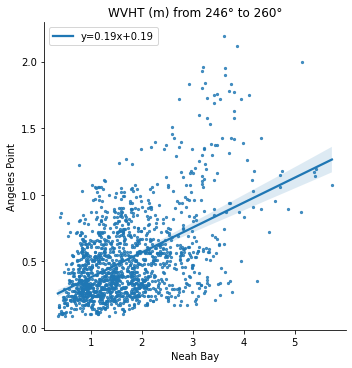

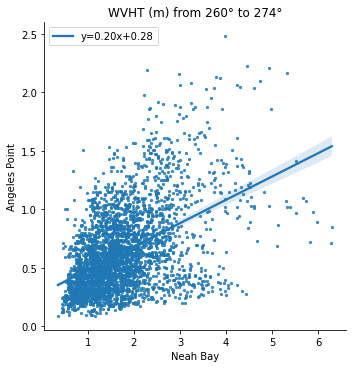

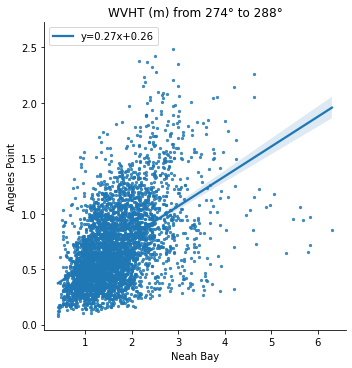

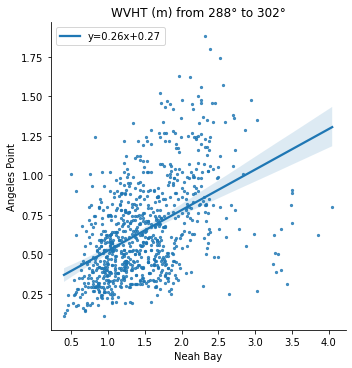

In [8]:
# Drop the NaNs so the linear regression works
one_wvht_df = one_wvht_df.dropna()
two_wvht_df = two_wvht_df.dropna()
three_wvht_df = three_wvht_df.dropna()
four_wvht_df = four_wvht_df.dropna()

# Section 1. get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(one_wvht_df['Neah Bay WVHT m'],one_wvht_df['Angeles Point WVHT m'])

p = sns.lmplot(x='Neah Bay WVHT m', y='Angeles Point WVHT m', data=one_wvht_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='WVHT (m) from 246° to 260°', xlabel='Neah Bay', ylabel='Angeles Point')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope,intercept)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
# L_labels[1].set_text(label_line_2)

# Section 2
slope_two, intercept_two, r_value_two, p_value_two, std_err_two = stats.linregress(two_wvht_df['Neah Bay WVHT m'],two_wvht_df['Angeles Point WVHT m'])

p = sns.lmplot(x='Neah Bay WVHT m', y='Angeles Point WVHT m', data=two_wvht_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='WVHT (m) from 260° to 274°', xlabel='Neah Bay', ylabel='Angeles Point')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_two,intercept_two)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
# L_labels[1].set_text(label_line_2)

# Section 3
slope_three, intercept_three, r_value_three, p_value_three, std_err_three = stats.linregress(three_wvht_df['Neah Bay WVHT m'],three_wvht_df['Angeles Point WVHT m'])

p = sns.lmplot(x='Neah Bay WVHT m', y='Angeles Point WVHT m', data=three_wvht_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='WVHT (m) from 274° to 288°', xlabel='Neah Bay', ylabel='Angeles Point')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_three,intercept_three)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
# L_labels[1].set_text(label_line_2)

# Section 4
slope_four, intercept_four, r_value_four, p_value_four, std_err_four = stats.linregress(four_wvht_df['Neah Bay WVHT m'],four_wvht_df['Angeles Point WVHT m'])

p = sns.lmplot(x='Neah Bay WVHT m', y='Angeles Point WVHT m', data=four_wvht_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='WVHT (m) from 288° to 302°', xlabel='Neah Bay', ylabel='Angeles Point')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_four,intercept_four)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
# L_labels[1].set_text(label_line_2)

print('r squared:',r_value**2, r_value_two**2, r_value_three**2, r_value_four**2)
# print(p_value,p_value_two,p_value_three,p_value_four)

r squared: 0.22113422483086384


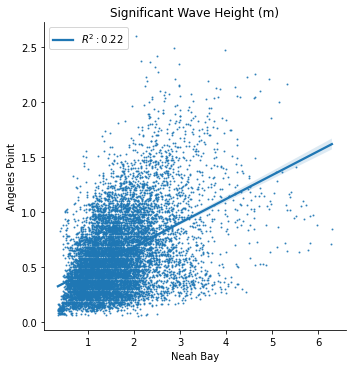

In [9]:
# WVHT linear regression

# Dataframe
angeles_wvht = angeles_df['WVHT m']
neah_wvht = neah_df['WVHT m']

wvht_df = pd.concat([angeles_wvht,neah_wvht], axis=1)
wvht_df.columns.values[0]='Angeles Point WVHT m'
wvht_df.columns.values[1]='Neah Bay WVHT m'

wvht_df = wvht_df.dropna()

# Stats
slope, intercept, r_value, p_value, std_err = stats.linregress(wvht_df['Neah Bay WVHT m'],wvht_df['Angeles Point WVHT m'])

# Plot
p = sns.lmplot(x='Neah Bay WVHT m',y='Angeles Point WVHT m', data=wvht_df, fit_reg=True, scatter_kws={"s": 1},line_kws={'label':"Linear Reg"}, height=5, legend=True)# truncate=False) 
p.set(title='Significant Wave Height (m)', xlabel='Neah Bay', ylabel='Angeles Point')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope,intercept)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
L_labels[-1].set_text(label_line_2)
print('r squared:',r_value**2)

r squared: 0.11677833641856329


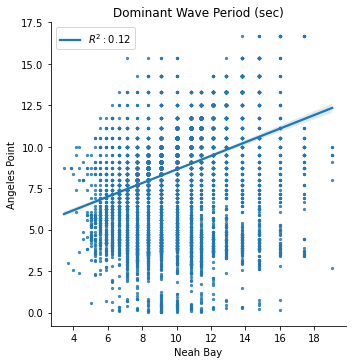

In [10]:
# DPD linear regression

# Dataframe
angeles_dpd = angeles_df['DPD sec']
neah_dpd = neah_df['DPD sec']
dpd_df = pd.concat([angeles_dpd,neah_dpd], axis=1)
dpd_df.columns.values[0]='Angeles DPD sec'
dpd_df.columns.values[1]='Neah DPD sec'
dpd_df = dpd_df.dropna()

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(dpd_df['Neah DPD sec'],dpd_df['Angeles DPD sec'])

# Plot
p = sns.lmplot(x='Neah DPD sec', y='Angeles DPD sec', data=dpd_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='Dominant Wave Period (sec)', xlabel='Neah Bay', ylabel='Angeles Point')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope,intercept)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
L_labels[-1].set_text(label_line_2)
print('r squared:',r_value**2)

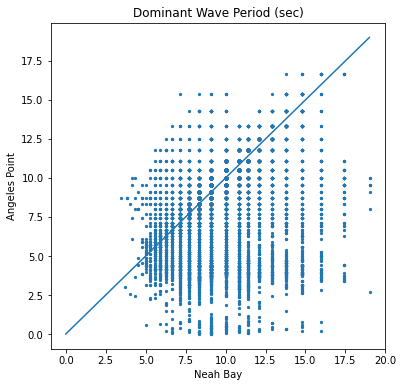

In [11]:
# DPD plot with 1 to 1 line (y=x)

# Scatter plot
fig, ax1 = plt.subplots(figsize=(6,6))
ax1.set(title='Dominant Wave Period (sec)', 
        xlabel='Neah Bay', 
        ylabel='Angeles Point')
ax1.scatter(x=dpd_df['Neah DPD sec'], y=dpd_df['Angeles DPD sec'], s=5)

# Plot y=x
x = np.linspace(0,19,num=20)
y = 1*x
ax1.plot(x, y)

In [12]:
# Calculation for Angeles Point wavelength
wavelength_ap = pd.DataFrame(index=angeles_df.index)
wavelength_nb = pd.DataFrame(index=neah_df.index)

# Wavelength = (([g]*Wave Period^2/2*pi)*sqrt(tanh(4*pi^2*Water Depth)/Wave Period^2*[g]))
# λ = (([g]*P^2/2*pi)*sqrt(tanh(4*pi^2*d)/P^2*[g]))
wavelength_ap['Angeles wavelength-inside tanh()'] = ((math.pi**2)*4*12.5)/((angeles_df['DPD sec']**2)*9.81)
wavelength_ap['Angeles wavelength (m)'] = ((9.81*(angeles_df['DPD sec']**2))/(2*math.pi))*np.sqrt(np.tanh(wavelength_ap['Angeles wavelength-inside tanh()']))

wavelength_nb['Neah wavelength-inside tanh()'] = ((math.pi**2)*4*12.5)/((neah_df['DPD sec']**2)*9.81)
wavelength_nb['Neah wavelength (m)'] = ((9.81*(neah_df['DPD sec']**2))/(2*math.pi))*np.sqrt(np.tanh(wavelength_nb['Neah wavelength-inside tanh()']))

r squared: 0.11692021448063343


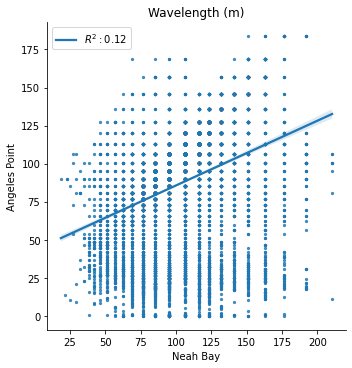

In [13]:
# Wavelength linear regression

# Dataframe
angeles_wvlength = wavelength_ap['Angeles wavelength (m)']
neah_wvlength = wavelength_nb['Neah wavelength (m)']
wavelength_df = pd.concat([angeles_wvlength,neah_wvlength], axis=1)
wavelength_df = wavelength_df.dropna()

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(wavelength_df['Neah wavelength (m)'],wavelength_df['Angeles wavelength (m)'])

# Plot
p = sns.lmplot(x='Neah wavelength (m)', y='Angeles wavelength (m)', data=wavelength_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='Wavelength (m)', xlabel='Neah Bay', ylabel='Angeles Point')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope,intercept)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
L_labels[-1].set_text(label_line_2)
print('r squared:',r_value**2)

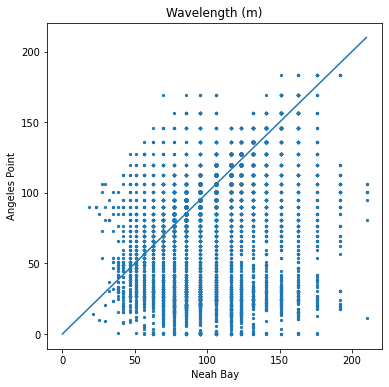

In [14]:
# Wavelength plot with 1 to 1 line (y=1x)

# Scatter plot
fig, ax1 = plt.subplots(figsize=(6,6))
ax1.set(title='Wavelength (m)', 
        xlabel='Neah Bay', 
        ylabel='Angeles Point')
ax1.scatter(x=wavelength_nb['Neah wavelength (m)'], y=wavelength_ap['Angeles wavelength (m)'], s=5)

# Plot y=x
x = np.linspace(0,210,num=20)
y = 1*x
ax1.plot(x, y)

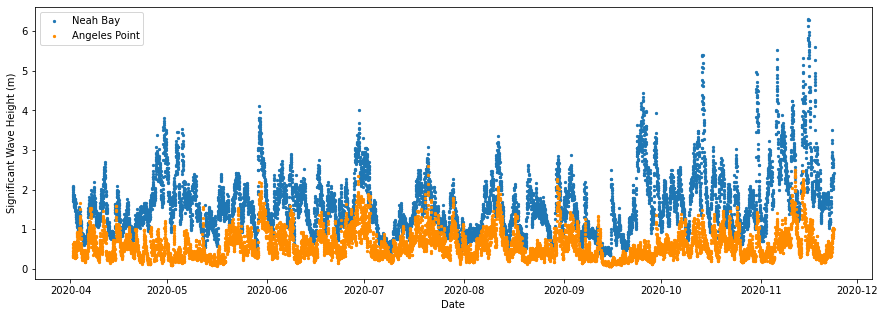

In [15]:
# Plot significant wave height

# Neah bay
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.set(xlabel='Date',
       ylabel='Significant Wave Height (m)')
ax1.scatter(x=neah_df.index, y=neah_df['WVHT m'], s=5)

# Angeles Point
ax1.scatter(x=angeles_df.index, y=angeles_df['WVHT m'], c='darkorange', s=5)

ax1.legend(['Neah Bay','Angeles Point'])

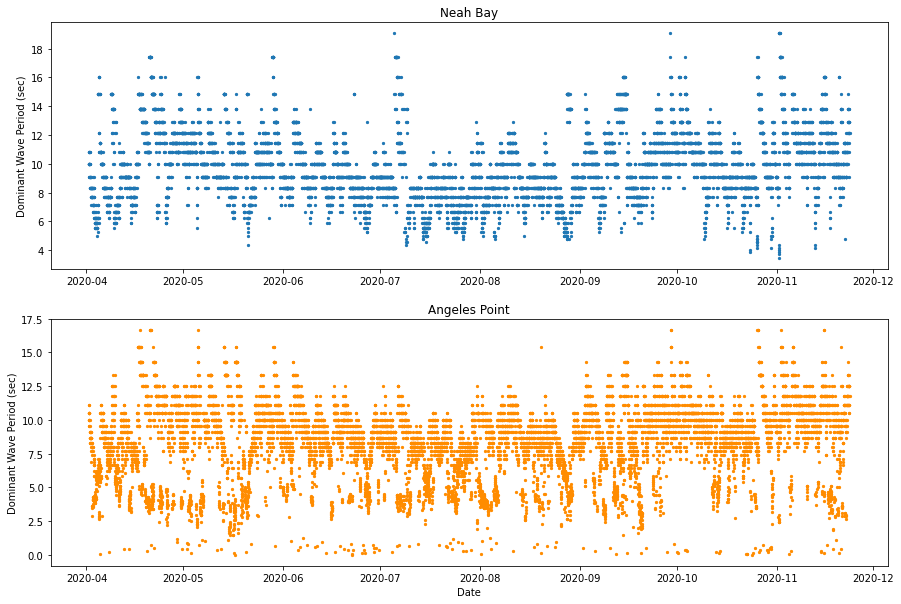

In [33]:
# Plot Dominant Wave Period

# Neah bay
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10))
ax1.set(title='Neah Bay',
        ylabel='Dominant Wave Period (sec)')
ax1.scatter(x=neah_df.index, y=neah_df['DPD sec'], s=5)

# Angeles Point
ax2.set(title='Angeles Point',
        xlabel='Date',
       ylabel='Dominant Wave Period (sec)')
ax2.scatter(x=angeles_df.index, y=angeles_df['DPD sec'], s=5, c='darkorange')


[Text(0, 0.5, 'Wave Direction (degrees)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Angeles Point')]

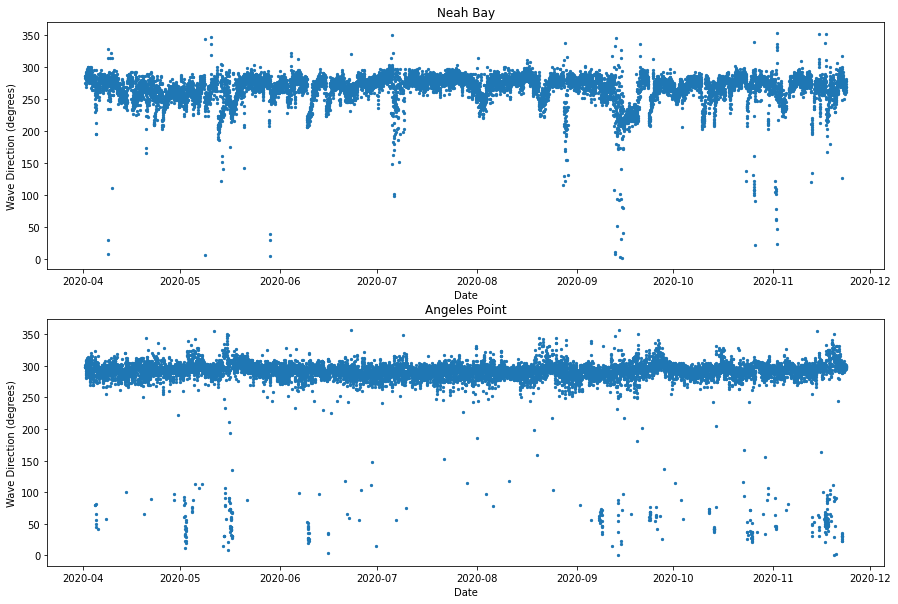

In [40]:
# Scatter wave direction
#   North is 0 degrees
#   East is 90 degrees
#   South is 180 degrees
#   West is 270 degrees

# Neah Bay
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10))
ax1.scatter(x=neah_df.index, y=neah_df['MWD degT'], s=5)
ax1.set(title='Neah Bay',
        xlabel='Date',
        ylabel='Wave Direction (degrees)')

ax2.scatter(x=angeles_df.index, y=angeles_df['MWD deg'], s=5)
ax2.set(title='Angeles Point',
        xlabel='Date',
        ylabel='Wave Direction (degrees)')